# 예측 보수 Predictive Maintenance (PM)

- 보수의 종류
  > 고장 후 보수: 기기가 고장이 나면 보수를 하는 것   
  > 정기적인 보수: 일정한 시간 간격으로 보수를 하는 것    
  > 예측 보수: 고장을 예측하여 적절한 시점에 미리 보수를 하는 것    
- 예제
 - 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측

## PM 회귀 모델
- TTF(time to fail): 고장까지 남은 시간을 예측하는 회귀 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.02.12.png?raw=1" align='left'>

## PM 분류 모델 (이진 분류)
- U (Unsafe): TTF가 주어진 경계치 이하로 낮은 위험한 상태
- U 값이 0/1을 갖는 이진 분류 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.03.35.png?raw=1" align='left'>

## PM 분류 모델 (다중  분류)
- U (Unsafe): 위험한 상태를 2개 이상으로 분류
- U 값이 0/1/2 세가지를 갖는 다중 분류 모델로 구현

<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.45.50.png?raw=1" align='left'>

## 기본 라이브러리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 훈련 데이터
- 스페이스로 구분된 숫자 원시 (raw) 데이터를 데이터프레임으로 읽는다
 - DataFrame:액셀과 같은 테이블 구조
- 매 사이클별로 항공기 엔진 운영 상태(State) 제공
- 고장 시점 정보 제공

In [3]:
path1 = 'http://azuremlsamples.azureml.net/templatedata/PM_train.txt'
df_train_raw = pd.read_csv(path1, sep = ' ', header=None)
print(df_train_raw.shape)
df_train_raw[:3]

(20631, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN


### 컬럼 이름은 미리 알려져 있다

In [4]:
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

- 컬럼 (변수) 설명
 -	__id__: 엔진 ID (1~100)
 -	__cycle__: 엔진별 운행 시퀀스 번호, (1~ 고장시점 까지)
 -	__setting1__ to __setting3__: 엔진 운영 설정 변수
 -	__s1__ to __s21__: 센서 값


In [5]:
# 불필요한 컬럼 삭제 (마지막 두 컬럼)
df_train_raw.drop([26,27], axis=1, inplace=True)

In [6]:
# 컬럼 이름 변경
df_train_raw.columns = col_names
df_train_raw[185:195] 
# 엔진 1에서 엔진 2 데이터로 바뀌는 부분이 192행이다

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
185,1,186,0.0027,-0.0003,100.0,518.67,643.51,1595.16,1426.30,14.62,...,520.08,2388.25,8123.45,8.5227,0.03,397,2388,100.0,38.47,23.0564
186,1,187,-0.0047,-0.0000,100.0,518.67,643.32,1592.10,1427.27,14.62,...,519.53,2388.28,8115.67,8.5218,0.03,396,2388,100.0,38.42,23.0822
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085
194,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,522.58,2387.99,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250


In [6]:
# 데이터의 기초 통계 보기
df_train_raw.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


- 100개의 엔진이 있고 각각 1~362 사이클 실행 정보가 있다.
- 마지막 사이클 번호가 고장난 시점이다.

In [7]:
# 데이터프레임의 기본 정보 보기
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

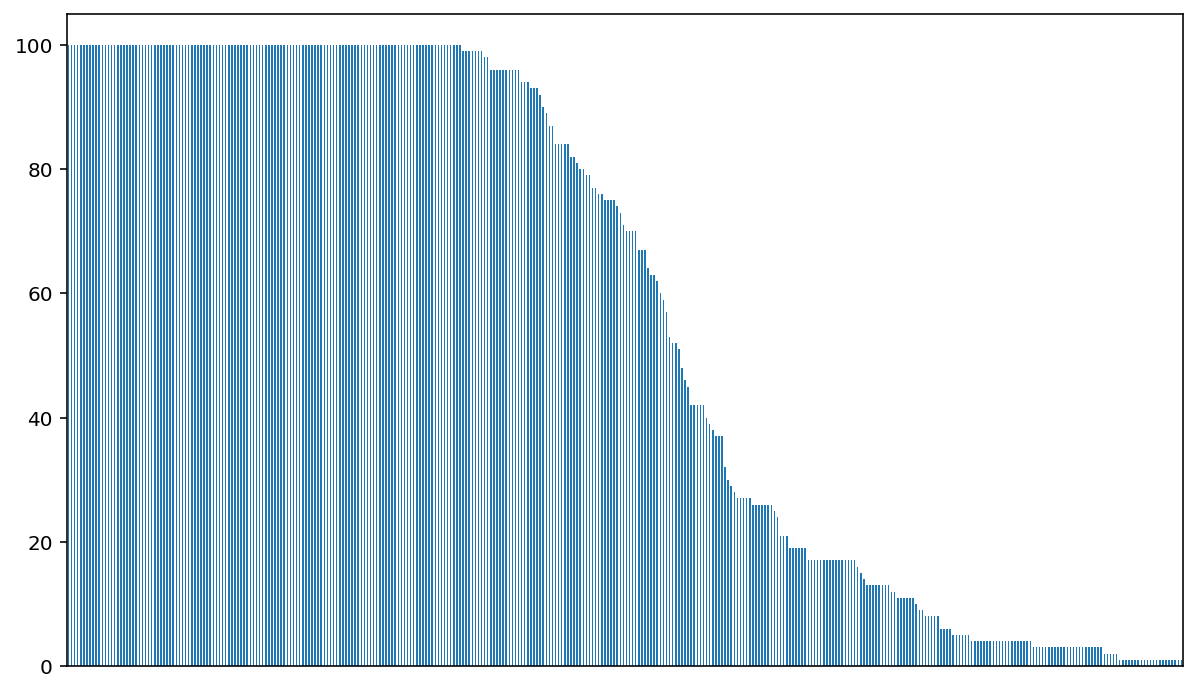

In [25]:
# 운행사이클 별 빈도수 보기 (엔진의 수가 100대 있음)
plt.figure(figsize=(10,10))
df_train_raw.cycle.value_counts().plot(kind='bar',figsize=(10,6))
plt.xticks([])
plt.show()

## 테스트 데이터
- 고장날 시점 정보는 주어지지 않고 임의의 시점까지의 운행 데이터만 주어짐
- 이 데이터를 보고 미래, 언제 고장날지를 예측하는 테스트를 해야 함

In [11]:
path2 = 'http://azuremlsamples.azureml.net/templatedata/PM_test.txt'
df_test_raw = pd.read_csv(path2, sep = ' ', header=None)
print(df_test_raw.shape)
df_test_raw.head()

(13096, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [12]:
# 26, 27 열 삭제
df_test_raw.drop([26,27], axis=1, inplace=True)
df_test_raw.columns = col_names
df_test_raw[:3]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [13]:
# 테스트 데이터 기본 통계 보기
df_test_raw.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


- 100개의 엔진이 있고 사이클 최대 값은 303이다. 
- (주의) 이 테스트 데이터에서는 고장 시점 정보는 들어 있지 않다
- 실제 고장 시점까지의 시간(time to failure, TTF)은 별도의 정답 파일로 제공한다

## 정답 파일
- 테스트 데이터 이후 얼마를 더 돌다 고장이 났는지를 알려주는 정답이 들어 있다
- 정답을 ground truth 데이터라고도 부른다

In [14]:
path3 = 'http://azuremlsamples.azureml.net/templatedata/PM_truth.txt'
df_truth = pd.read_csv(path3, sep = ' ', header=None)
df_truth.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [15]:
# 두번 째 컬럼은 삭제하고, 컬럼 이름을 ttf로 변경한다
# time to fail
df_truth.drop([1], axis=1, inplace=True)
df_truth.columns = ['ttf']
df_truth.head()

,ttf
0,112
1,98
2,69
3,82
4,91


# 레이블(y) 컬럼 생성
- 회귀 분석에서는 잔여시간(TTF)을 추정하며 각 상태(State)에서 앞으로 남은 잔여시간을 계산한 후 이를 예측하는 회귀 모델을 만든다
- 분류 분석에서는 앞으로 얼마 기간 이내에 고장 날지 여부를 예측하는 것임
 - 이진 분류: 예를 들어 30 사이클 이내에 고장 여부를 분류한다 (0/1 구분)
 - 다중 분류: 예를 들어 30 사이클 이내에 고장이 날지 또는 15 사이클 이내 고장이 날지를 나누어 예측한다 (0/1/2 구분)
- 회귀 및 분류를 위한 레이블을 만들겠다

## 데이터 사본 저장

In [16]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

### TTF 구하기
- TTF를 RUL(Remaining Useful Life)라고도 한다
- 잔여수명 (RUL) 컬럼 추가
- 같은 엔진 ID에 대해서 최대값이 "수명"을 나타내므로 이를 먼저 구하고
- 이를 rul 데이터프레임에 저장한다
- 같은 'id'를 같는 행들을 하나의 데이터프레임으로 만드는 groupby를 사용한다

In [17]:
rul = pd.DataFrame(df_train.groupby('id')['cycle'].max()).reset_index()
rul

,id,cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


- 각 행별로 ttf 값은, 각 엔진별 rul 테이블의 수명에서 현재 시점 cycle 값을 뺀 값이다
- rul 데이터프레임에서 수명을 나타내는 cycle 컬럼 이름을 max라고 바꾸겠다
- 잔여 수명을 나타내는 'ttf' 컬럼을 추가한다

In [19]:
rul.columns = ['id', 'max']
df_train = df_train.merge(rul, on=['id'], how='left')
df_train['ttf'] = df_train['max'] - df_train['cycle']
df_train.drop('max', axis=1, inplace=True)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### 분류용 레이블
- 이진분류를 위해서, 앞으로 30 사이클 이내에 고장이 날 지를 예측하는 이진 분류용 레이블을 만든다
 - bnc (binary classifiation)
- 다중 분류를 위해서, 앞으로 30 및 15 사이클 이내에 고장이 날 지를 구분하는 다중 분류용 레이블을 만든다
 - mcc (multi-class classification)

In [20]:
w1 = 30
w2 = 15
df_train['label_bnc'] = np.where(df_train['ttf'] <= w1, 1, 0 )
df_train['label_mcc'] = df_train['label_bnc']
df_train.loc[df_train['ttf'] <= w2, 'label_mcc'] = 2
df_train[:5]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [21]:
df_train[173:193]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
173,1,174,-0.0001,-0.0002,100.0,518.67,642.64,1599.81,1422.58,14.62,...,8.4476,0.03,393,2388,100.0,38.57,23.0357,18,1,1
174,1,175,0.0001,0.0002,100.0,518.67,643.61,1603.29,1422.52,14.62,...,8.4890,0.03,394,2388,100.0,38.58,23.1573,17,1,1
175,1,176,-0.0020,-0.0003,100.0,518.67,642.86,1592.27,1422.73,14.62,...,8.4853,0.03,394,2388,100.0,38.72,23.2491,16,1,1
176,1,177,-0.0038,-0.0003,100.0,518.67,643.79,1602.02,1423.99,14.62,...,8.4779,0.03,396,2388,100.0,38.63,23.1673,15,1,2
177,1,178,-0.0001,0.0002,100.0,518.67,643.38,1605.33,1424.65,14.62,...,8.4770,0.03,395,2388,100.0,38.65,23.1770,14,1,2
178,1,179,0.0023,-0.0003,100.0,518.67,642.86,1592.56,1429.45,14.62,...,8.4947,0.03,395,2388,100.0,38.77,23.1888,13,1,2
179,1,180,-0.0024,0.0000,100.0,518.67,643.58,1599.87,1417.14,14.62,...,8.4737,0.03,395,2388,100.0,38.86,23.0070,12,1,2
180,1,181,-0.0006,0.0005,100.0,518.67,643.44,1596.71,1420.64,14.62,...,8.4720,0.03,397,2388,100.0,38.34,23.1652,11,1,2
181,1,182,-0.0010,0.0003,100.0,518.67,644.21,1602.08,1426.62,14.62,...,8.5158,0.03,397,2388,100.0,38.43,23.1787,10,1,2
182,1,183,0.0001,0.0001,100.0,518.67,643.24,1597.23,1419.03,14.62,...,8.5041,0.03,396,2388,100.0,38.56,23.1302,9,1,2


## 스케일링
- 모든 센서 값의 최소, 최대 값이 0~1 범위를 갖도록 스케일링한다 
- 스케일링 대상이 아닌 ['id','cycle','ttf','label_bnc','label_mcc'] 컬럼은 제외하기 위해서 difference 함수를 사용한다

In [23]:
# Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
cols_sc = df_train.columns.difference(['id','cycle','ttf','label_bnc','label_mcc'])
min_max_scaler = MinMaxScaler()
df_train[cols_sc] = min_max_scaler.fit_transform(df_train[cols_sc])
df_train[:3]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0


## 테스트 데이터에 대한 스케일링
- (주의!) 테스트 데이터를 스케일링 할 때 훈련 데이터에서 사용한 스케일링(즉, 훈련 데이터의 최대값, 최소값 범위)을 사용해야 한다
 - 테스트 데이터에 대해서는 1 이상 또는 0 이하의 값이 나올 수 있다
 - fit_transform() 대신 transform() 함수를 사용해야 한다

In [24]:
df_test[cols_sc] = min_max_scaler.transform(df_test[cols_sc])
df_test[:3]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348


## 테스트 데이터의 정답 계산
- 모델의 성능을 최종 평가하기 위해서는 정답을 알아야 한다
- 테스트 데이터의 마지막 사이클 값에, 따로 얻은 정답 테이블의 값('more')을 더해주어야 한다

In [25]:
# max 컬럼 생성
rul = pd.DataFrame(df_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
df_truth.columns = ['more']
df_truth['id'] = df_truth.index + 1
df_truth['max'] = rul['max'] + df_truth['more']
df_truth.drop('more', axis=1, inplace=True)

In [26]:
# ttf 계산
df_test = df_test.merge(df_truth, on=['id'], how='left')
df_test['ttf'] = df_test['max'] - df_test['cycle']
df_test.drop('max', axis=1, inplace=True)
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138


In [27]:
# 테스트 데이터에 대해서도 이진 및 다중 분류 레이블을 추가한다
df_test['label_bnc'] = np.where(df_test['ttf'] <= w1, 1, 0 )
df_test['label_mcc'] = df_test['label_bnc']
df_test.loc[df_test['ttf'] <= w2, 'label_mcc'] = 2
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0


## 전처리 결과 저장
- 레이블이 포함된 훈련 및 테스트 데이터를 파일로 저장해 둔다

In [28]:
df_train.to_csv('PM_train_pre.csv', index=False)
df_test.to_csv('PM_test_pre.csv', index=False)

# 탐색적 분석
-  전처리된 데이터를 파일에서 읽는다

In [29]:
df_train = pd.read_csv('PM_train_pre.csv')
df_test = pd.read_csv('PM_test_pre.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0


In [30]:
# 모델 입력(X)으로 사용할 특성을 선택한다 (여기서는 모두 사용)
featurs = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

In [31]:
# ttf와 상관관계가 큰 순으로 소팅해 본다
df_train[featurs].corrwith(df_train.ttf).sort_values(ascending=False)

s12         0.671983
s7          0.657223
s21         0.635662
s20         0.629428
setting2   -0.001948
setting1   -0.003198
s6         -0.128348
s14        -0.306769
s9         -0.390102
s13        -0.562569
s8         -0.563968
s3         -0.584520
s17        -0.606154
s2         -0.606484
s15        -0.642667
s4         -0.678948
s11        -0.696228
setting3         NaN
s1               NaN
s5               NaN
s10              NaN
s16              NaN
s18              NaN
s19              NaN
dtype: float64

In [32]:
# ttf와의 상관관계가 큰 특성의 리스트
corr_big_featurs = ['s12', 's7', 's21', 's20', 's6', 's14', 
    's9', 's13', 's8', 's3', 's17', 's2', 's15', 's4', 's11']

## 상관관계 히트맵

In [33]:
corr_big_featurs = corr_big_featurs +  ['ttf']

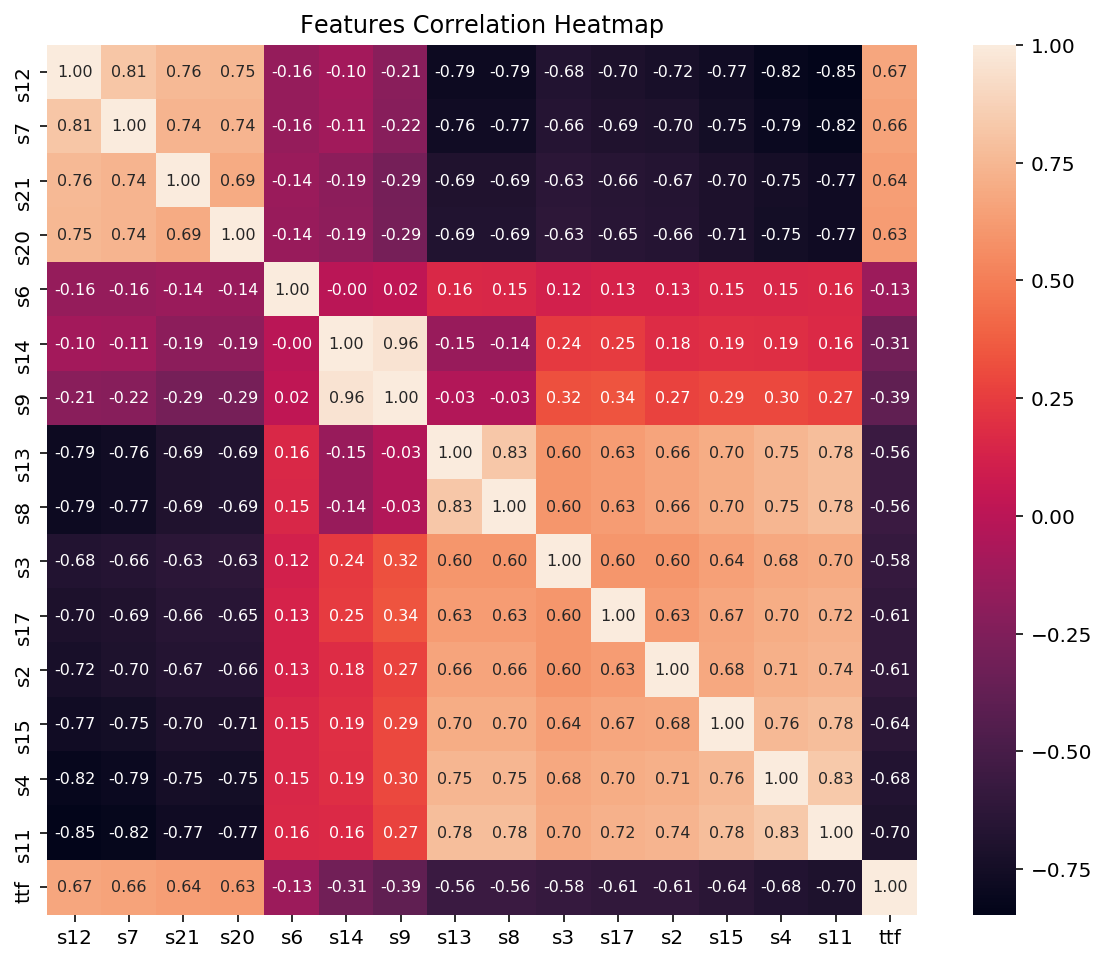

In [34]:
import seaborn as sns
cm = np.corrcoef(df_train[corr_big_featurs].values.T)
# sns.set(font_scale=1.0)
fig = plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
  annot_kws={'size': 8}, yticklabels=corr_big_featurs, 
                 xticklabels=corr_big_featurs)
plt.title('Features Correlation Heatmap')
plt.show()

- 높은 상관관계를 갖는 특성들(> 0.8): (s14, s9), (s11, s4), (s11, s7), (s11, s12), (s4, s12), (s8,s13),  (s7, s12)  
- 이들은 향후 특성 선택에서 제거 대상이 될 수 있다.

# 시각화
- 여러 특성의 분포를 파악하는 함수를 정의한다
- 센서 s에 대해서 랜덤하게 선택한 N개의 엔진 데이터 보기

In [35]:
def explore_col(s, N): 
    fig = plt.figure(figsize=(10, 8))
    sub1 = fig.add_subplot(221) 
    sub1.set_title(s +' histogram') 
    sub1.hist(df_train[s])

    sub2 = fig.add_subplot(222)
    sub2.set_title(s +' boxplot')
    sub2.boxplot(df_train[s])
    
    select_engines = np.random.choice(range(1,101), N, replace=False)
        
    sub3 = fig.add_subplot(223)
    sub3.set_title('time series: ' + s +' / cycle')
    sub3.set_xlabel('cycle')
    for i in select_engines:
        df = df_train[['cycle', s]][df_train.id == i]
        sub3.plot(df['cycle'],df[s])
    
    sub4 = fig.add_subplot(224)
    sub4.set_title("scatter: "+ s + " / ttf (regr label)")
    sub4.set_xlabel('ttf')
    sub4.scatter(df_train['ttf'],df_train[s], s=2)
    plt.show()

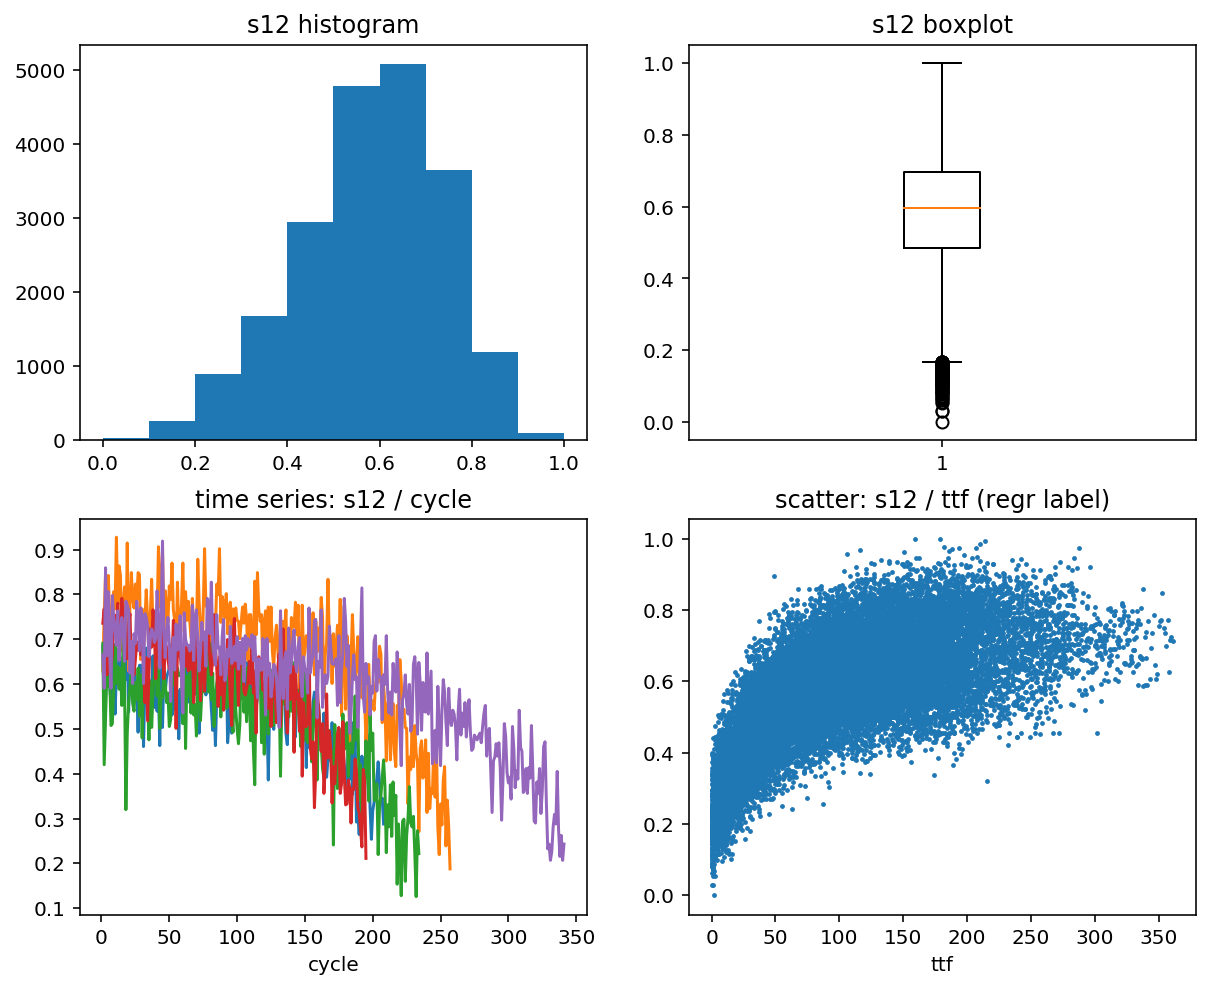

In [36]:
explore_col("s12", 5)

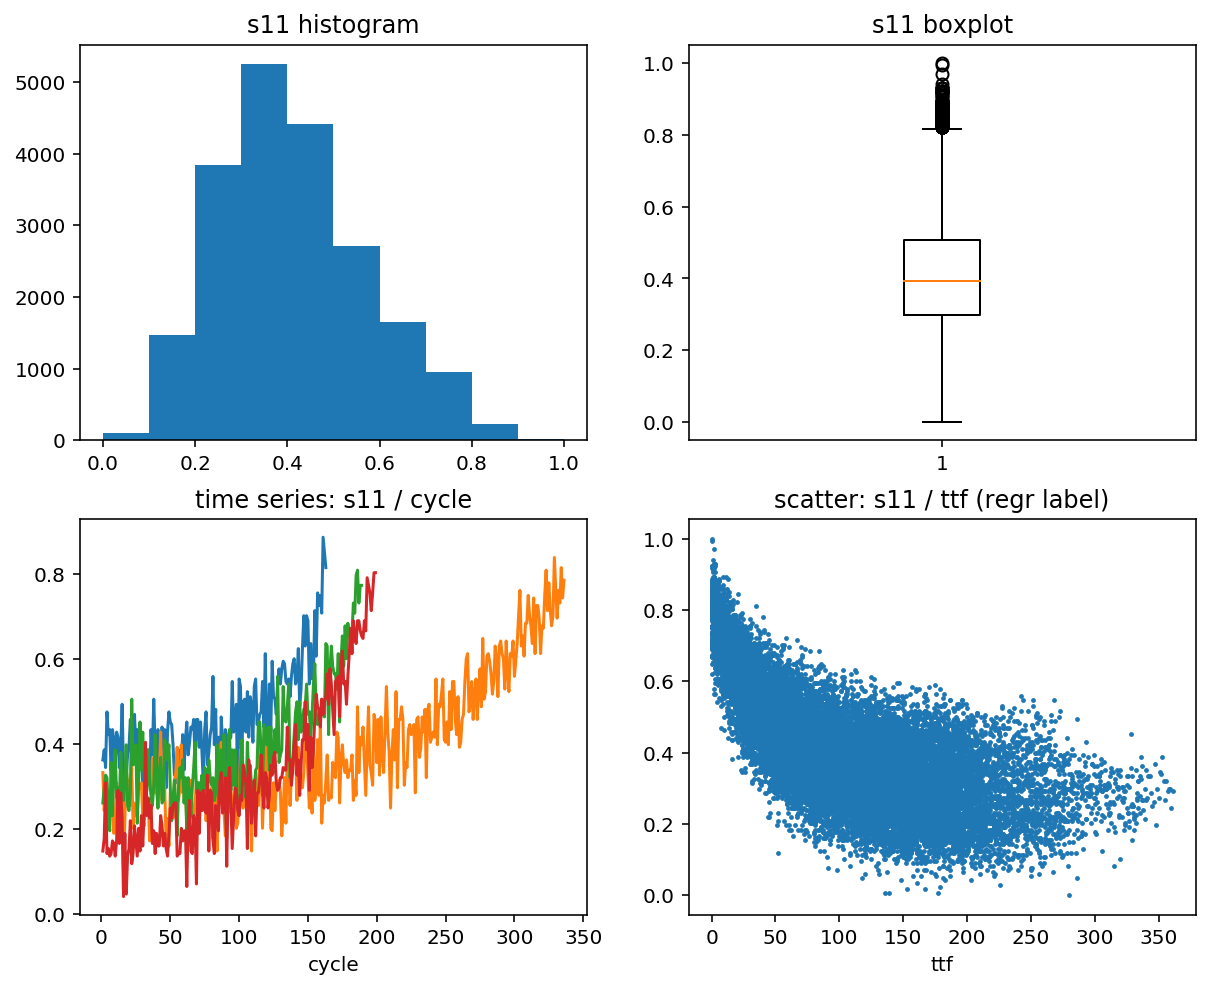

In [37]:
explore_col("s11", 4)

## 시간에 따른 센서값 변화 보기
- 센서 s에 대해서 랜덤하게 선택한 N개의 엔진 데이터 보기

In [38]:
def plot_time_series(s, N):    
    fig, axes = plt.subplots(N, 1, sharex=True, figsize = (15, 15))
    fig.suptitle(s + ' time series / cycle', fontsize=15)
    
    select_engines = np.random.choice(range(1,101), N, replace=False).tolist()
    
    for e_id in select_engines:
        df = df_train[['cycle', s]][df_train.id == e_id]
        i = select_engines.index(e_id)
        axes[i].plot(df['cycle'],df[s])
        axes[i].set_ylabel('engine ' + str(e_id))
        axes[i].set_xlabel('cycle')
        #axes[i].set_title('engine ' + str(e_id), loc='right')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

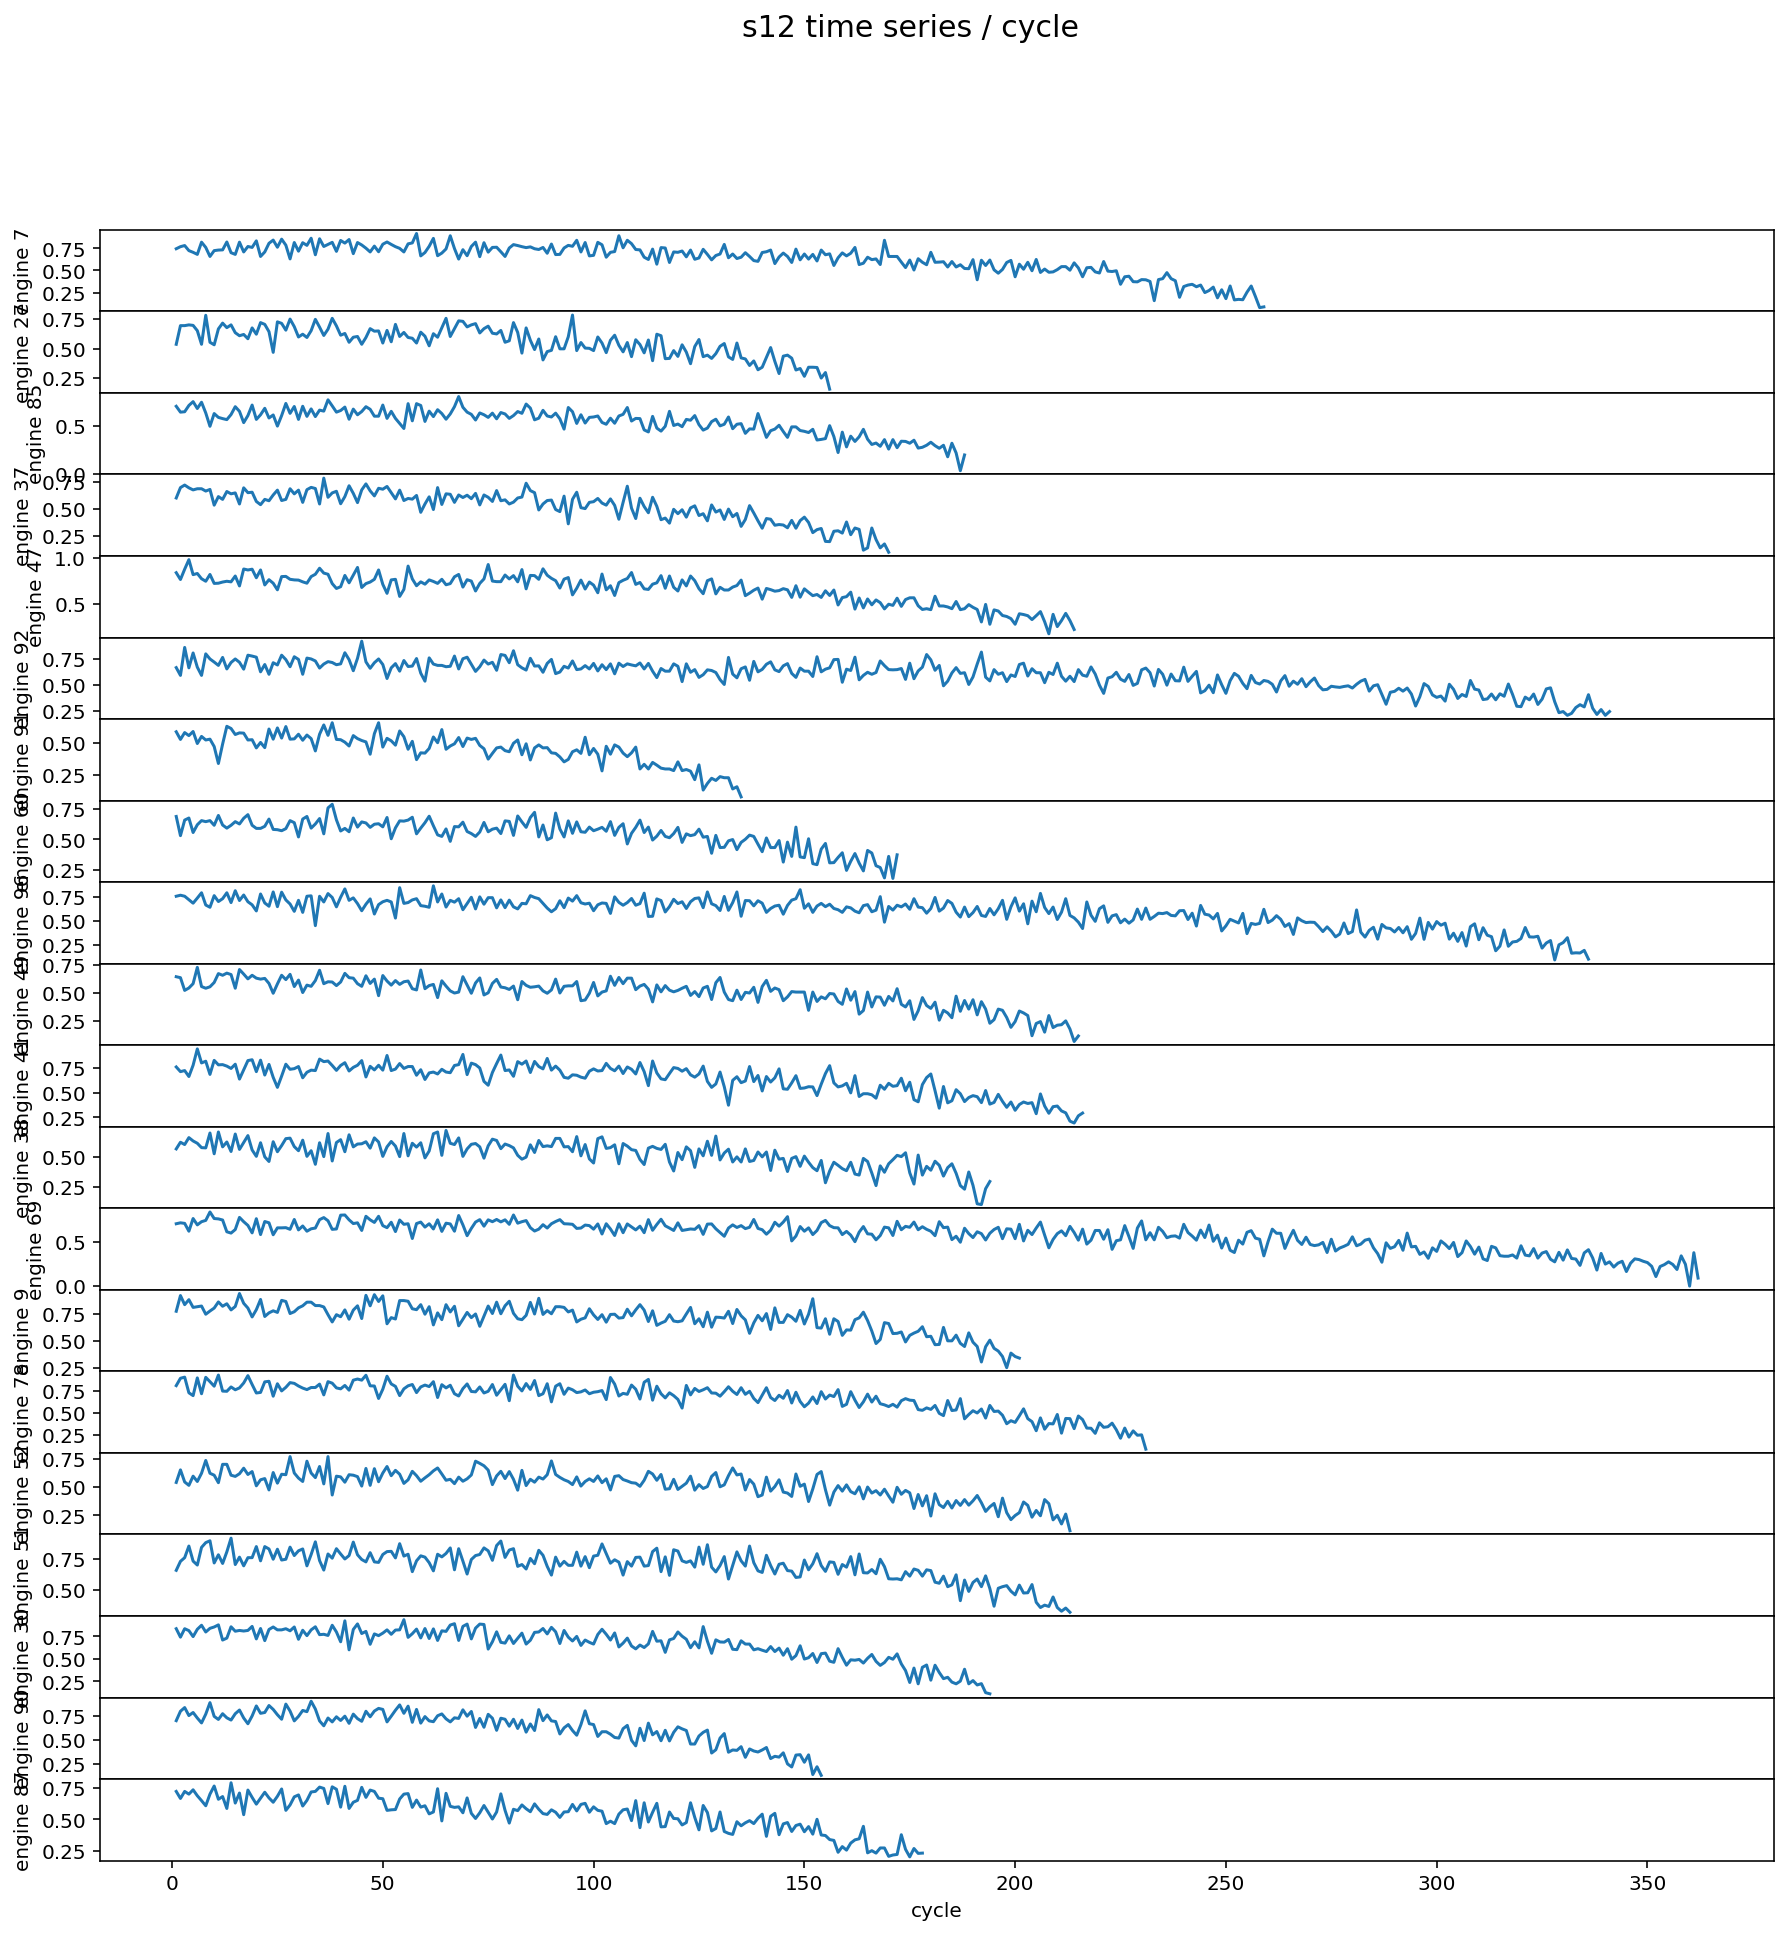

In [39]:
plot_time_series('s12',20)

# 고장시점 예측
- 회귀분석

In [40]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV

## 입력(X)과 레이블(y) 설정

In [42]:
features_sensors = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

X_train = df_train[features]
y_train = df_train['ttf']

## 훈련데이터 일부를 검증 데이터로 사용

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)# 학습 및 검증 데이터 크기 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15473, 24), (5158, 24), (15473,), (5158,))

# 회귀분석 성능 지표
- 대표적인 성능 측정 지표 보기
 - RMSE
 - MAE
 - R squared

In [44]:
def get_regression_metrics(model, actual, predicted):
    regr_metrics = {
      'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
      'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
      'R^2' : metrics.r2_score(actual, predicted)}

    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

## 상관 계수와 중요 특성값

In [45]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

## 잔차를 그리는 함수

In [46]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data', s=2)
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data', s=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

## 선형 회귀 모델

In [47]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.581, R^2 test: 0.575


,Linear Regression
Root Mean Squared Error,44.832348
Mean Absolute Error,34.144522
R^2,0.574765


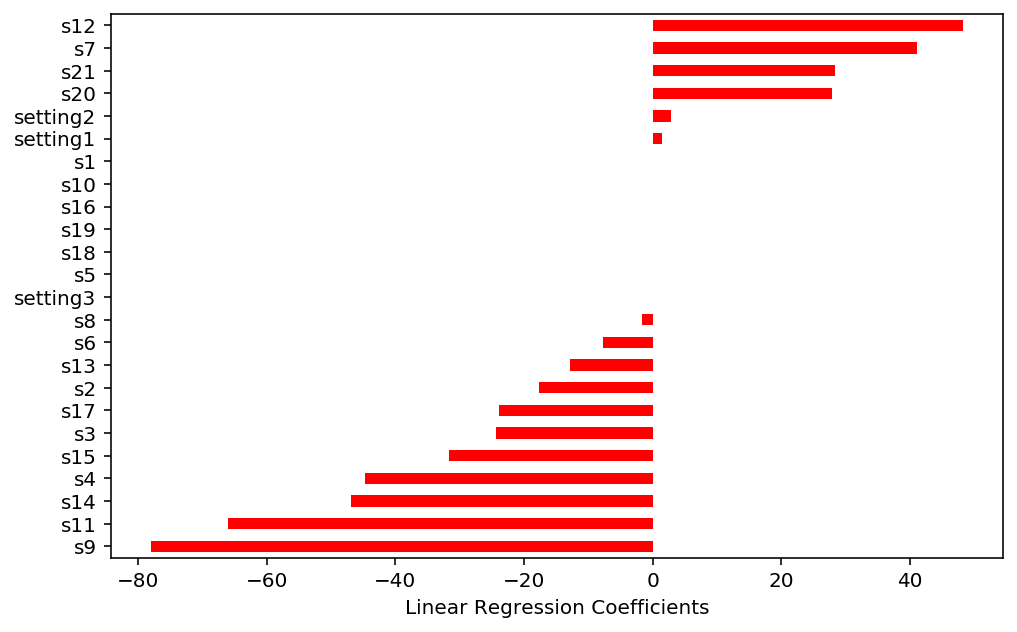

In [48]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

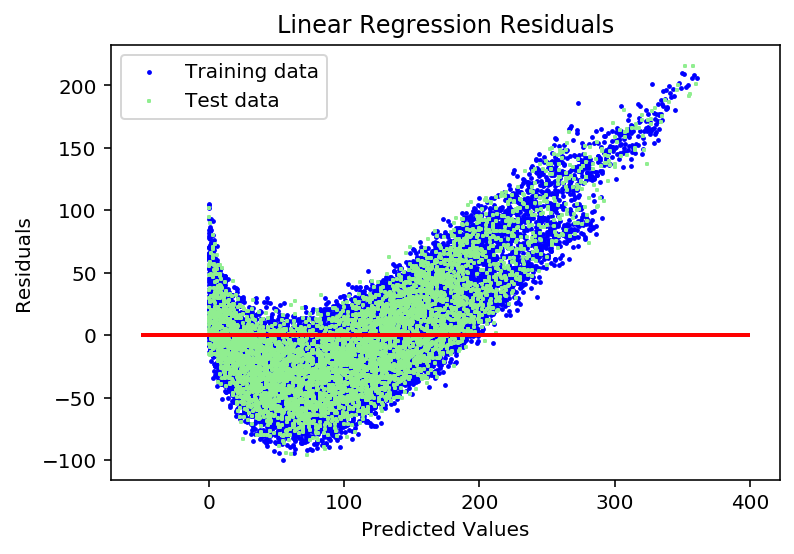

In [49]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

## 랜덤 포레스트

In [50]:
rf = RandomForestRegressor(n_estimators=20) # original features

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.940, R^2 test: 0.616


,Random Forest Regression
Root Mean Squared Error,42.592108
Mean Absolute Error,30.173352
R^2,0.616201


In [51]:
# plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

In [52]:
# plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

### 실제값과 예측치 보기

In [53]:
rf_pred_dict = {
    'Actual' : y_test,
    'Prediction' : y_test_predict }  
rf_pred = pd.DataFrame.from_dict(rf_pred_dict)
rf_pred[:100]

,Actual,Prediction
4952,157,125.00
6402,9,20.70
10062,59,54.75
5961,25,63.85
6870,117,134.20
...,...,...
12144,162,98.10
3113,191,131.30
12972,146,93.25
15624,129,152.80


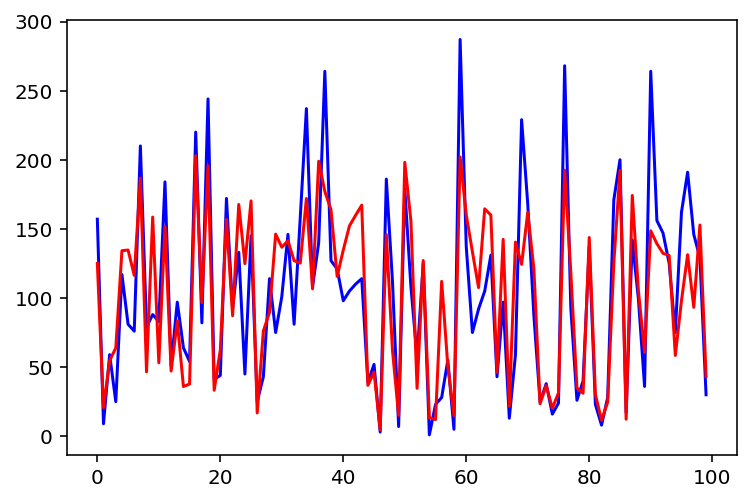

In [54]:
plt.plot(y_test[:100].values, c='b')
plt.plot(y_test_predict[:100], c='r')

## 실제 테스트 데이터로 테스트 하기
- 검증 데이터가 아니라

In [55]:
# X_train = df_train[features]
# y_train = df_train['ttf']
# X_test = df_test[features]
# y_test = df_test['ttf']

In [56]:
# linreg = linear_model.LinearRegression()
# linreg.fit(X_train, y_train)

# y_test_predict = linreg.predict(X_test)
# y_train_predict = linreg.predict(X_train)

# print('R^2 training: %.3f, R^2 test: %.3f' % (
#       (metrics.r2_score(y_train, y_train_predict)), 
#       (metrics.r2_score(y_test, y_test_predict))))

# linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
# linreg_metrics

# PM 이진 분류

In [62]:
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [63]:
X_train = df_train[features]
y_train = df_train['label_bnc']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)# 학습 및 검증 데이터 크기 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15473, 24), (5158, 24), (15473,), (5158,))

# 로지스틱 회귀

In [65]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 컨퓨전 매트릭스
- 정확도, 정밀도, 리콜, f1점수 보기

In [66]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4324   75]
 [ 124  635]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4399
           1       0.89      0.84      0.86       759

    accuracy                           0.96      5158
   macro avg       0.93      0.91      0.92      5158
weighted avg       0.96      0.96      0.96      5158



### ROC 커브 그리기

In [67]:
def draw_roc(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test.values, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

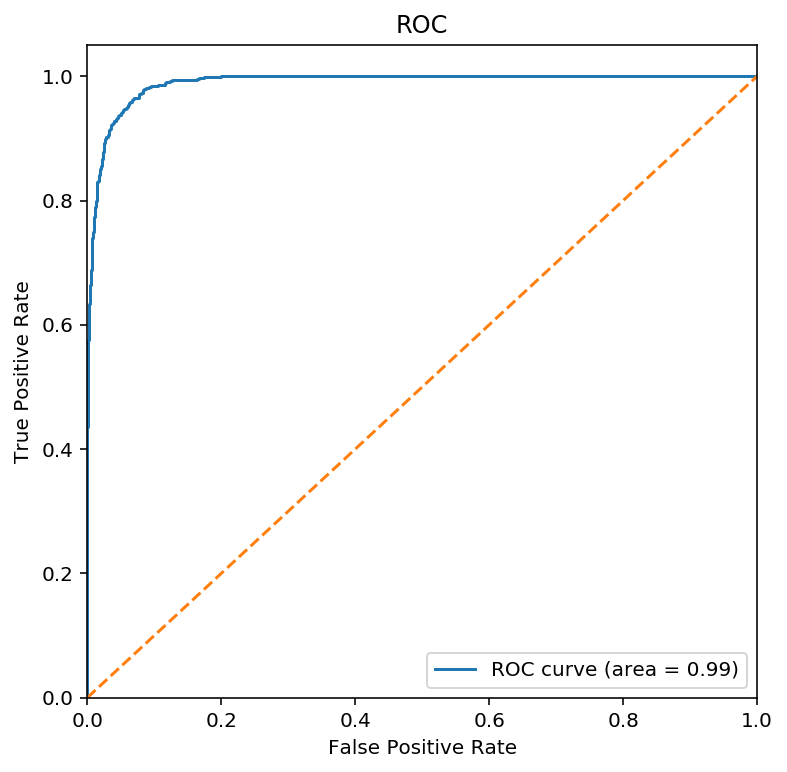

In [68]:
y_score = model.predict_proba(X_test)[:,1]
draw_roc(y_test, y_score)

# 랜덤 포레스트

In [69]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [70]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4332   67]
 [ 114  645]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4399
           1       0.91      0.85      0.88       759

    accuracy                           0.96      5158
   macro avg       0.94      0.92      0.93      5158
weighted avg       0.96      0.96      0.96      5158



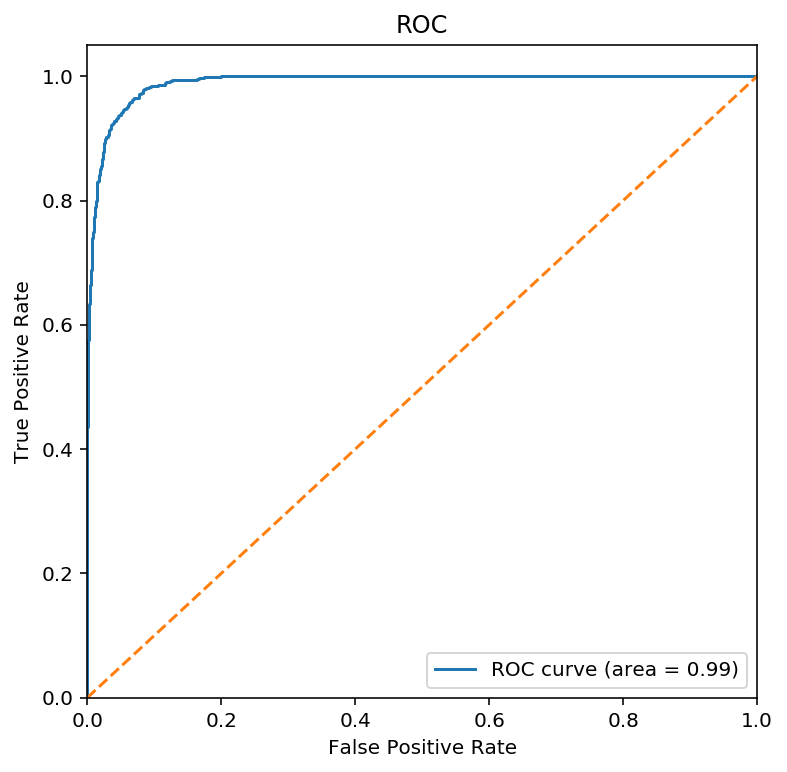

In [71]:
y_score = model.predict_proba(X_test)[:,1]
draw_roc(y_test, y_score)

## 테스트 데이터 사용

In [72]:
X_train = df_train[features]
y_train = df_train['label_bnc']
X_test = df_test[features] 
y_test = df_test['label_bnc']

In [73]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[12722    42]
 [  141   191]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12764
           1       0.82      0.58      0.68       332

    accuracy                           0.99     13096
   macro avg       0.90      0.79      0.83     13096
weighted avg       0.98      0.99      0.98     13096

